In [1]:
from algoaux import *
from lib import *
from dataShaper import *
from models import cnn
from graphs import *
import re
import os
import traceback
sns.set_theme(style="whitegrid")
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

In [2]:
def populateDataLog(input_dir):
    dataLog={}
    for file in os.listdir(input_dir):
        if file != ".DS_Store":
            lossArray = []
            gapArray = []
            localGapArray =[]
            a=open(input_dir+file, "r").read().replace("0>", "").split("\n")
            for item in a:
                try:
                    b=item.strip().replace(":", "").split()
                    loss, gap, local_gap = b[2],b[4], b[-1]
                    lossArray.append(loss)
                    gapArray.append(gap)
                    localGapArray.append(local_gap)
                except:
                    pass
            dataLog[file]={
                "lossArray" :lossArray,
                "gapArray" : gapArray,
                "localGapArray" : localGapArray
            }
    return dataLog

def read_result_from_txt(path):
    files = os.listdir(path)
    #data_file = [file
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            with open(path+file,'r') as f:
                lines = f.readlines()
            result = [line for line in lines if line.startswith("t_")]
            losses = np.zeros(len(result))
            gap = np.zeros(len(result))
            for k,v in enumerate(result):
                modified = re.split('[\n : ]',v)
                #print(modified[4])
                losses[k] = float(modified[6])
                gap[k] = float(modified[10])
            dataLog[int(file.split("-")[1])] = {"losses":losses,
                      "gap":gap}
    return dataLog

def read_result_from_csv(path):
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            try:
                pd_file = pd.read_csv(os.path.join(path,file), index_col=0)
                dataLog[str(file.split("_")[1].split('.')[0])] = pd_file
                #dataLog[]
            except:
                print("Skipping unrelated file ...")
                pass
    return dataLog

In [3]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

In [4]:
def plotDeFW(floor, graph_type, feature, path_analysis, save_path, save=False ,metric="loss", average=False):
    
    path_dmfw = os.path.join(path_analysis,f'{graph_type}-{feature}/')
    path_defw = os.path.join(path_analysis,"Defw/"+f'{feature}/'+f'{graph_type}/')
    
    dmfw = read_result_from_txt(path_dmfw)
    defw = read_result_from_csv(path_defw)
    keys_defw = str(floor)
    keys_dmfw = int(floor)
    
    fig = plt.figure(figsize=(10,5))
    #plt.title(f"Floor{floor} - {graph_type} Graph", fontsize=14,**hfont)
    if metric=="loss":
        plt.plot(dmfw[keys_dmfw]["losses"][1:-1], label="DMFW",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if average:
            plt.plot(average_loss(dmfw[keys_dmfw]["losses"][1:-1]), label="DMFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            
        plt.plot(defw[keys_defw]["Loss"][1:-1].values, label="DeFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        if average:
            plt.plot(average_loss(defw[keys_defw]["Loss"][1:-1]), label="DeFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Loss",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            plt.savefig(save_path+f"Floor{floor}-{graph_type}-{feature}.png")
        plt.show()
        
    elif metric=="gap":
        plt.plot(dmfw[keys_dmfw]["gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.plot(defw[keys_defw]["Gap"][1:-1].values, label="DeFW",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path+f"Floor{floor}-{graph_type}-{feature}.png")
        plt.show()
    else:
        raise ValueError("Unrecognized metric")

In [5]:
def plotOFW(floor, graph_type, feature, path_dmfw, path_analysis, save_path, save=False ,metric="loss", average=False, indep_loss = False):
    #path_dmfw = os.path.join(path_analysis,f'new-{feature}/{graph_type}/alpha/')
    path_ofw = os.path.join(path_analysis,"Ofw/"+f'{feature}/')
    
    print(path_dmfw)
    
    #dmfw = read_result_from_txt(path_dmfw)
    dmfw = read_result_from_csv(path_dmfw)
    ofw = read_result_from_csv(path_ofw)
    
    #print(dmfw)

    
    real_value = [1,2,4,5]
    real_zone = []*len(real_value)
    
    keys_dmfw = str(floor)
    #print(keys_dmfw)
    keys_ofw = sorted([zone for zone in list(ofw.keys()) if zone.split("z")[0] == str(floor)])
    average_ofw = sum([ofw[zone] for zone in keys_ofw])/len(keys_ofw)
    
    print(f'Avg OFW {np.mean(average_ofw)}')
    print(f'Avg DMFW {np.mean(dmfw[keys_dmfw]["Loss"])}')
    
    
    for i in range(len(keys_ofw)):
        real_zone.append(real_value[i])
    
    fig = plt.figure(figsize=(10,5))
    if metric=="loss":
        if average==True:
            plt.plot(average_loss(dmfw[keys_dmfw]["Loss"][1:-1]), label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            if indep_loss:
                for zone, real in zip(keys_ofw,real_zone):
                    plt.plot(average_loss(ofw[zone]["Loss"][1:-1].values), ls='--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1)
            else:
                plt.plot(average_loss(average_ofw["Loss"][1:-1]),ls='--',label="OFW",marker='^', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1)
                
        elif average=="Full":
            plt.plot(dmfw[keys_dmfw]["Loss"][1:-1], label="DMFW ",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1,c="#8E94D6")
            plt.plot(average_loss(dmfw[keys_dmfw]["Loss"][1:-1]), label="DMFW Online Loss",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1.3, c="#8E94D6")
            plt.plot(average_ofw["Loss"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1, c="#DFA063")
            plt.plot(average_loss(average_ofw["Loss"][1:-1]),ls='--',label="OFW Online Loss",marker='^', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1.3, c="#DFA063")
        else:
            plt.plot(dmfw[keys_dmfw]["Loss"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            if indep_loss:
                for zone, real in zip(keys_ofw,real_zone):
                    plt.plot(ofw[zone]["Loss"][1:-1].values,ls = '--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=0.3)      
            else :
                plt.plot(average_ofw["Loss"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1)    
            
                
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["Loss"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Loss",**hfont)
        
    if metric=="gap":
        plt.plot(dmfw[keys_dmfw]["Gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if indep_loss:
            for zone, real in zip(keys_ofw,real_zone):
                plt.plot(ofw[zone]["Gap"][1:-1].values,ls = '--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                         markevery=[i for i in range(504) if i%10==0],linewidth=0.3)      
        else :
            plt.plot(average_ofw["Gap"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)    
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)  
        
    plt.xlabel("Iteration",**hfont)
    plt.yscale("log")
    if save:
        save_path_feat = save_path+f'{feature}/'
        if not os.path.exists(save_path_feat):
            os.makedirs(save_path_feat)
        plt.savefig(save_path_feat+f"Floor{floor}-{metric}-{graph_type}-{average}-{indep_loss}.png")
    plt.show()

In [6]:
def plotDMFW(path,path_to_save,metric,floor_idx, save=False):
    data = read_result_from_csv(path)
    key = [ele for ele in data.keys()][0]
    print(data)
    #print(np.mean(data[str(floor_idx)][metric][:-1]))
    plt.figure(figsize=(10,5))
    plt.plot(data[key][metric][1:-1],label="DMFW"+f' {metric}')#,marker='o', markersize=5,
                     #markevery=[i for i in range(504) if i%10==0], linewidth=1)
    if metric == "Loss":
        plt.plot(average_loss(data[key][metric][:-1]),ls='--',label="DMFW Online"+f' {metric}')#,marker='^', markersize=5,
                         #markevery=[i for i in range(504) if i%10==0], linewidth=1)
    plt.xticks(ticks=np.arange(len(data[key][metric][:-1]),step=50))
    plt.legend()
    plt.ylabel(metric,**hfont)
    plt.xlabel("Iteration",**hfont)
    plt.yscale("log")
    if save:
        plt.savefig(path_to_save+f'{metric}-F{floor_idx}')
    plt.show()

In [7]:
def plotPrediction(path, path_to_save,feature,zone_idx, floor_idx,begin,end, save=False):
    files = os.listdir(path)

    prediction_files = [file for file in files if (file.startswith("prediction")) and (file.split(".")[0][-1]==zone_idx) and (floor_idx in file)]
    #print(prediction_files)
    if prediction_files == []:
        print("---Failed to read floor index---")
        prediction_files = [file for file in files if (file.startswith("prediction")) and (file.split(".")[0][-1]==zone_idx)]
    print(prediction_files)
    resultpd = pd.read_csv(path+prediction_files[0],index_col=0)
    result_to_plot = resultpd.iloc[begin:end]
    mean = np.mean(np.abs(result_to_plot["Truth"]-result_to_plot["Prediction"]))
    std = np.std(np.abs(result_to_plot["Truth"]-result_to_plot["Prediction"]))
    plt.figure(figsize=(15,5))
    plt.title(f'Floor {floor_idx} - Zone {zone_idx}')
    plt.plot(result_to_plot["Truth"],label="Truth")
    plt.plot(result_to_plot["Prediction"],label=f"Prediction-MAE:{mean:.4f}-STD:{std:.4f}",ls='-')
    #plt.xticks(ticks=np.arange(result_to_plot.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    if save:
        plt.savefig(path_to_save+f'prediction-F{floor_idx}-zone{zone_idx}')
    plt.show()

In [8]:
def compare_alpha(path_graph):
    folders = os.listdir(path_graph)
    alphas = [ele for ele in folders if len(ele)==8]
    alphas_dict = {}
    for alpha in alphas:
        direct = os.path.join(path_graph,alpha+"/")
        alphas_dict[alpha] = read_result_from_csv(direct)
    return alphas_dict

In [9]:
def plot_loss_alphas(alphas_dict, alphas_value=None):
    plt.figure(figsize=(10,4))
    for keys in alphas_dict.keys():
        print(f'{keys} : {np.mean(alphas_dict[keys]["7"]["Loss"][:-1])}')
        plt.plot(average_loss(alphas_dict[keys]["7"]["Loss"][:-1]),label=keys)
        plt.legend()
        plt.yscale("log")
    print("-----------------")
    
def compare_alphas_graph(complete_dict, cycle_dict, line_dict, alpha_value):
    alpha_str = f'alpha0{alpha_value}'
    plt.figure(figsize=(10,4))
    print(f'Complete : {np.mean(complete_dict[alpha_str]["7"]["Loss"][:-1])}')
    print(f'Cycle : {np.mean(cycle_dict[alpha_str]["7"]["Loss"][:-1])}')
    print(f'Line : {np.mean(line_dict[alpha_str]["7"]["Loss"][:-1])}')
    plt.plot(average_loss(complete_dict[alpha_str]["7"]["Loss"][:-1]), label="Complete "+alpha_str)
    plt.plot(average_loss(cycle_dict[alpha_str]["7"]["Loss"][:-1]), label="Cycle "+alpha_str)
    plt.plot(average_loss(line_dict[alpha_str]["7"]["Loss"][:-1]), label="Line "+alpha_str)
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Average Loss")
    plt.yscale("log")

In [10]:
global_path2 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/complete/67Zone/alpha095-cut20april-hid64-64/"
def truth_distribution(path):
    files = os.listdir(path)
    predictions = sorted([file for file in files if "prediction" in file])
    selected = pd.DataFrame()
    for pred in predictions:
        csv = pd.read_csv(global_path2+pred,index_col=0)
        selected = pd.concat([selected,csv["Truth"].rename(f"{pred}".split("-")[1].split(".")[0])],axis=1)
    return selected
truths = truth_distribution(global_path2)

In [11]:
alpha_value = 95
zone = 1
nb_timestep = 288

In [12]:
def compare_prediction_zone(path,accro_path,floor,zone_idx, graph_type):
    #graph_type = ["complete"]#,"cycle","line","grid62"]
    zone_name = f'Floor{floor}Z{zone_idx}'
    cible_files = []
    result_pd = pd.DataFrame()
    for graph in graph_type:
        path_graph = os.path.join(path, f'{graph}/{accro_path}')
        files = os.listdir(path_graph)
        zone_pred = [file for file in files if zone_name in file]
        path_csv = os.path.join(path_graph, zone_pred[0])
        graph_result = pd.read_csv(path_csv, index_col=0)
        result_pd = pd.concat([result_pd, graph_result["Truth"].rename(f'Truth {graph}') ,graph_result["Prediction"].rename(f'{graph}')],axis=1)
    return result_pd

def plot_compare_prediction(path,accro_path,floor,zone_idx, graph_type,start=0, end=-1):
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
    plt.figure(figsize=(12,4))
    plt.title(f'Floor {floor} - Zone {zone_idx}')
    plt.plot(dataframe[f"Truth {graph_type[0]}"][start:end], label="Truth")
    for graph in graph_type:
        mean, std = np.mean(np.abs(dataframe[f"Truth {graph}"][start:end]-dataframe[f"{graph}"][start:end])),\
                                        np.std(dataframe[f"Truth {graph}"][start:end]-dataframe[f"{graph}"][start:end])
        plt.plot(dataframe[f"{graph}"][start:end], label=f"Prediction {graph} - MeanAE:{mean:.4f} - Std:{std:.4f}")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()

Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_6935/4007548372.py", line 5, in <module>
    try: plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_6935/4200942456.py", line 16, in plot_compare_prediction
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_6935/4200942456.py", line 10, in compare_prediction_zone
    path_csv = os.path.join(path_graph, zone_pred[0])
IndexError: list index out of range
Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_6935/4007548372.py", line 5, in <module>
    try: plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_6935

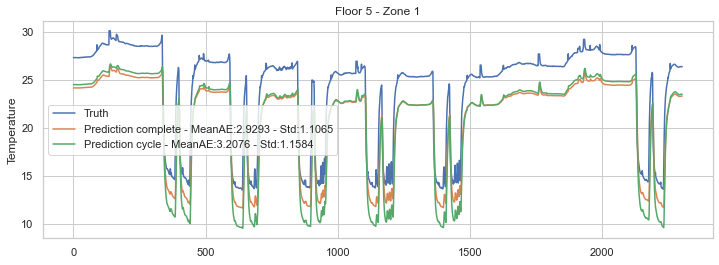

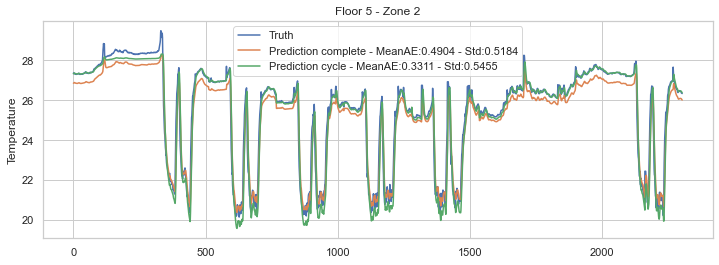

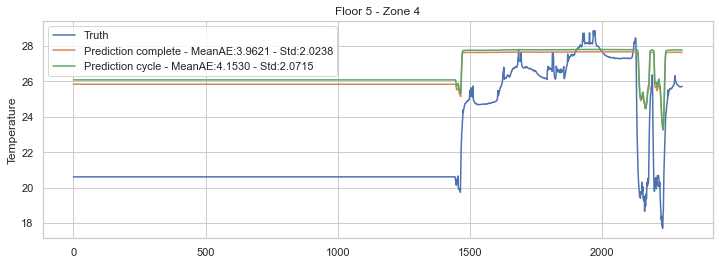

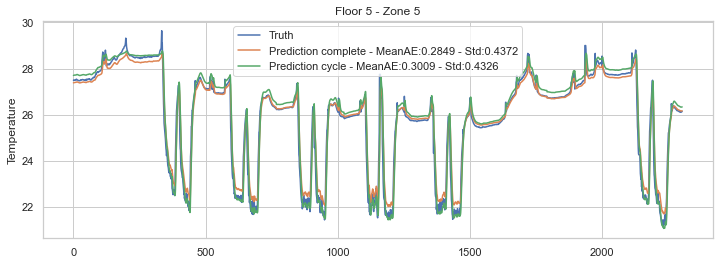

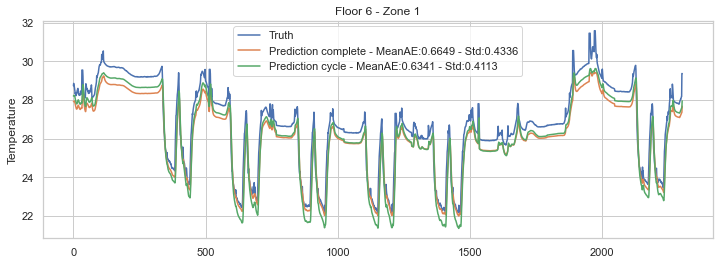

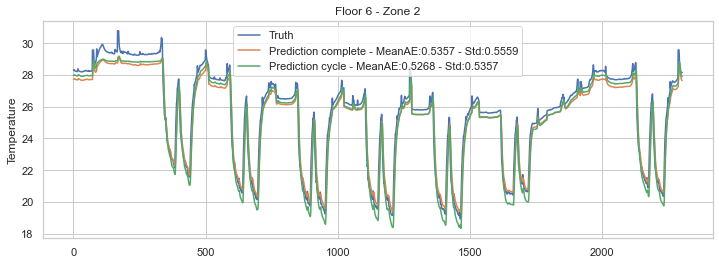

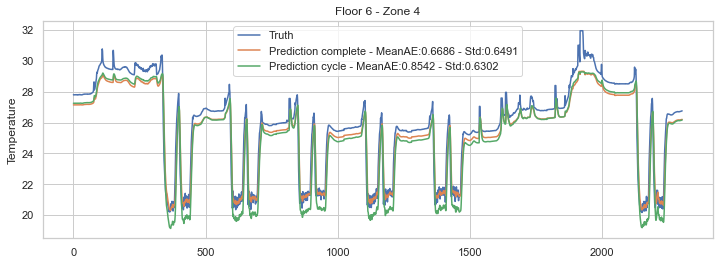

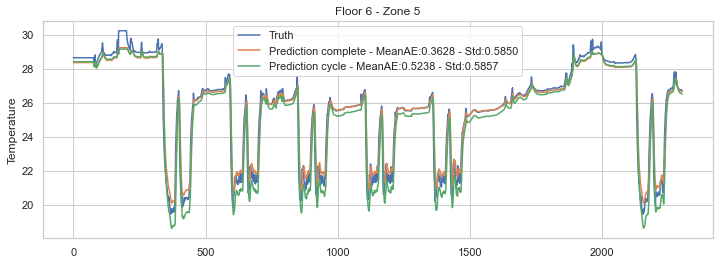

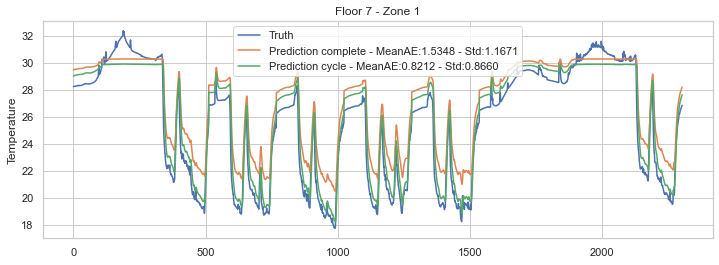

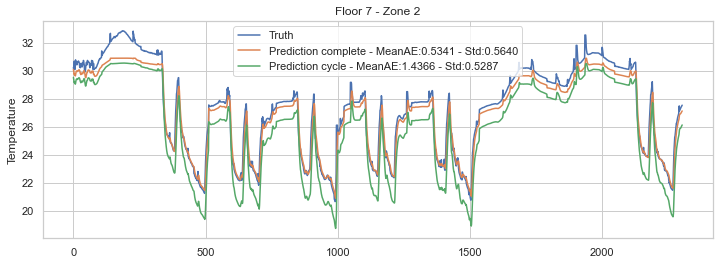

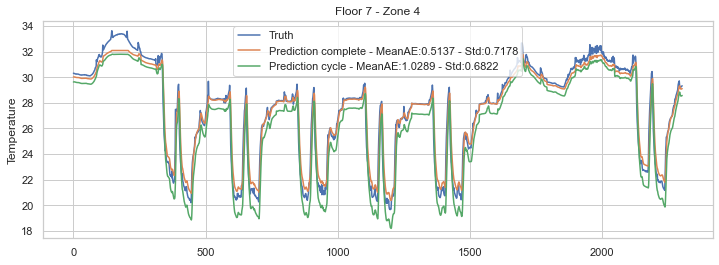

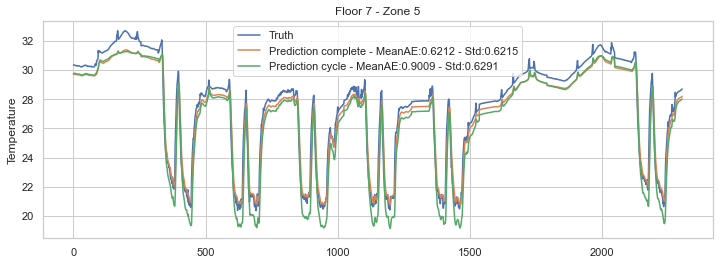

In [14]:
global_path = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/"
accro_path= "567Zone/alpha095-cut20april-hid64-64/"
for floor in [4,5,6,7]:
    for zone in [1,2,4,5]:
        try: plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle"], 0,8*nb_timestep)
        except Exception:
            traceback.print_exc()
            pass

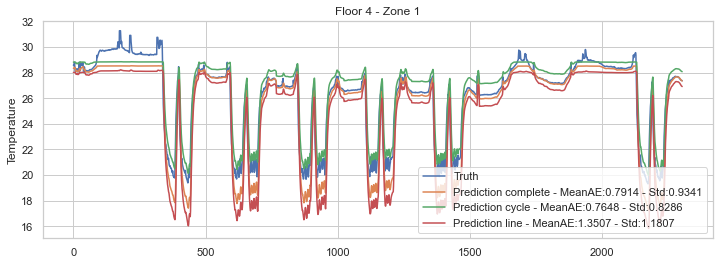

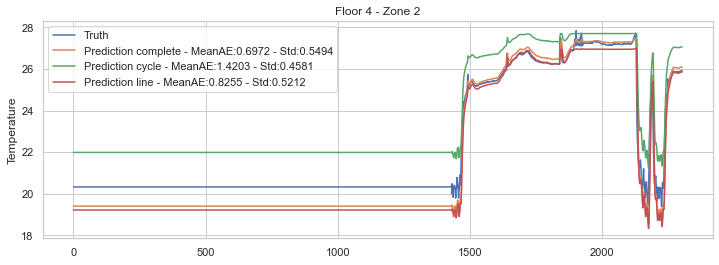

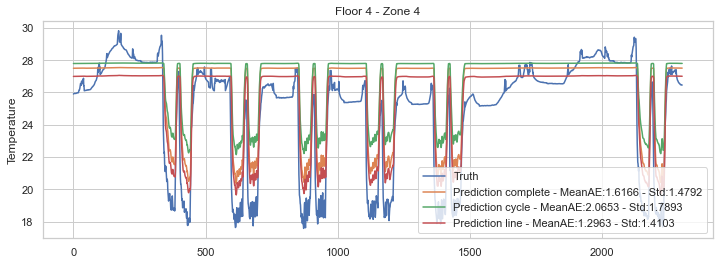

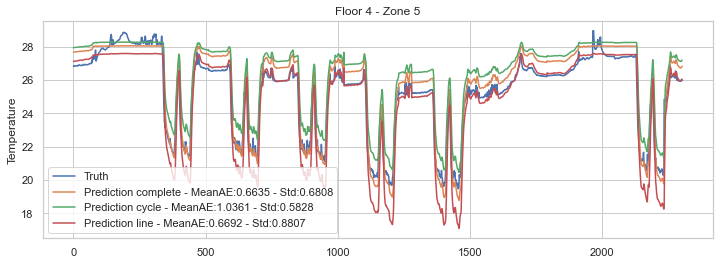

Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/1136252117.py", line 5, in <module>
    try:            plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle","line"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/4200942456.py", line 16, in plot_compare_prediction
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/4200942456.py", line 10, in compare_prediction_zone
    path_csv = os.path.join(path_graph, zone_pred[0])
IndexError: list index out of range


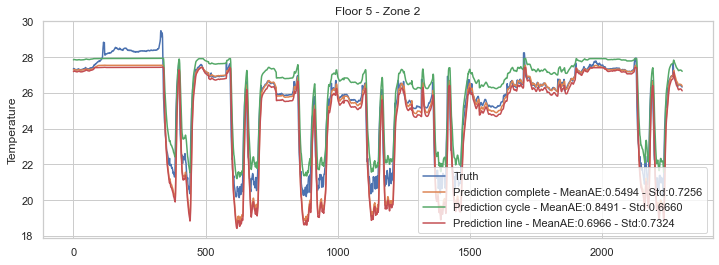

Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/1136252117.py", line 5, in <module>
    try:            plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle","line"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/4200942456.py", line 16, in plot_compare_prediction
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/4200942456.py", line 10, in compare_prediction_zone
    path_csv = os.path.join(path_graph, zone_pred[0])
IndexError: list index out of range


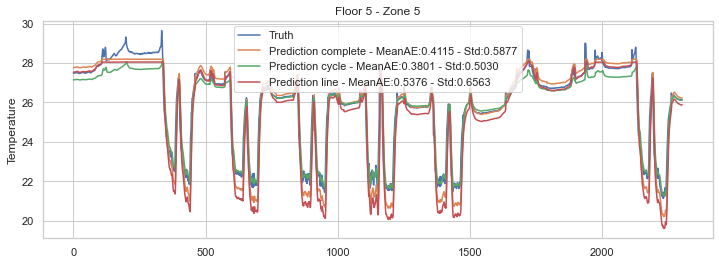

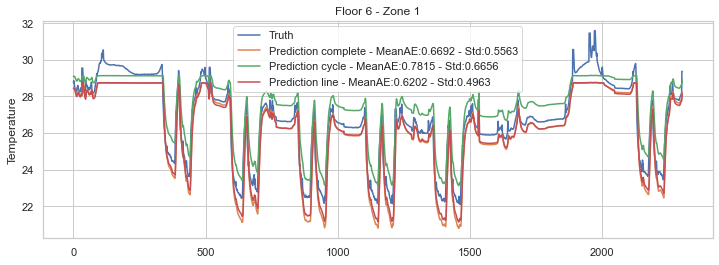

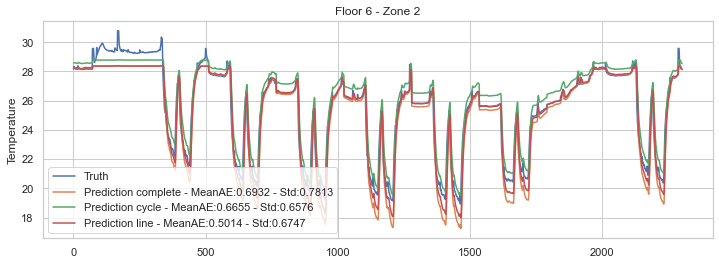

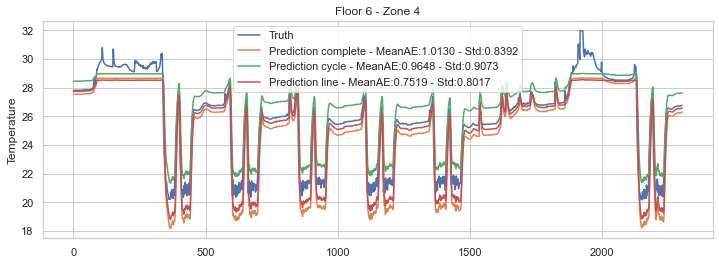

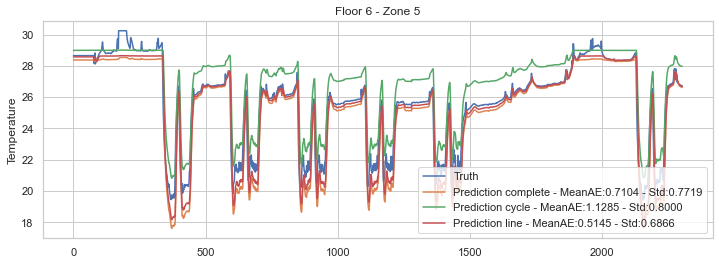

Traceback (most recent call last):
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/1136252117.py", line 5, in <module>
    try:            plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle","line"], 0,8*nb_timestep)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/4200942456.py", line 16, in plot_compare_prediction
    dataframe = compare_prediction_zone(path, accro_path, floor, zone_idx, graph_type)
  File "/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_14412/4200942456.py", line 10, in compare_prediction_zone
    path_csv = os.path.join(path_graph, zone_pred[0])
IndexError: list index out of range


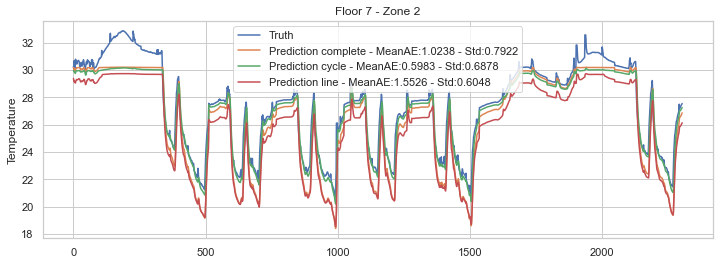

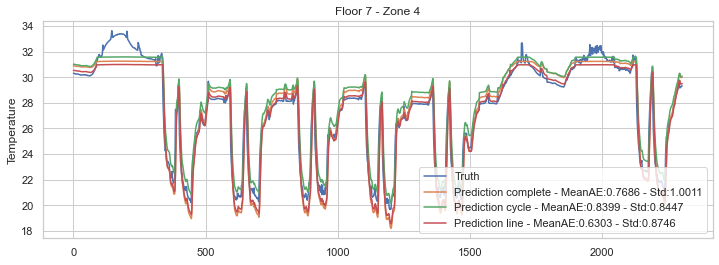

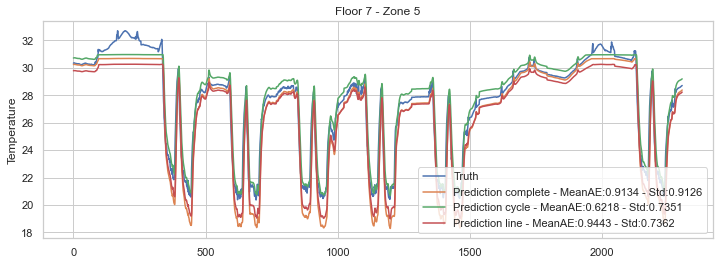

In [14]:
global_path = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/"
accro_path= "floor4567/alpha095-cut20april-removed_floors/"
for floor in [4,5,6,7]:
    for zone in [1,2,4,5]:
        try:            plot_compare_prediction(global_path,accro_path, floor, zone, ["complete","cycle","line"], 0,8*nb_timestep)
        except Exception: 
            traceback.print_exc() 
            pass

# Evaluate GridSearch F7Z1

---Hidden Unit 3---
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
{'log':         Iteration          Loss           Gap     Local Gap           Acc  \
0    0.000000e+00  1.086722e+00  1.974553e+00  1.974553e+00  4.335938e-01   
1    1.000000e+00  9.519712e-01  1.361100e+00  7.554996e-01  4.335938e-01   
2    2.000000e+00  1.034579e+00  1.359941e+00  1.357624e+00  4.335938e-01   
3    3.000000e+00  9.646080e-01  1.315095e+00  1.195378e+00  4.335938e-01   
4    4.000000e+00  8.633282e-01  1.140021e+00  4.699535e-01  4.550781e-01   
..            ...           ...           ...           ...           ...   
108  1.080000e+02  9.364391e-01  5.456336e-01  2.580132e-01  6.445312e-01   
109  1.090000e+02  8.621790e-01  5.457126e-01  5.543174e-01  6.445312e-01   
110  1.100000e+02  8.169625e-01  5.451788e-01  5.793505e-01  6.445312e-01   
111  1.110000e+02  8.802096e-01  5.430088e-01  3.234977e-01  6.445312e-01   
112  6.785188

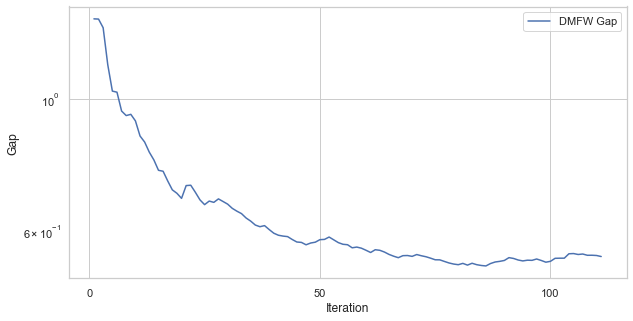

---Hidden Unit 5---
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
{'log':      Iteration      Loss            Gap  Local Gap           Acc  \
0          0.0  1.105236   1.704614e+00   1.704614  1.816406e-01   
1          1.0  0.970212   1.148448e+00   0.594717  1.816406e-01   
2          2.0  0.948017   9.747239e-01   0.637219  1.816406e-01   
3          3.0  0.850803   8.650510e-01   0.536953  1.816406e-01   
4          4.0  0.879978   8.003235e-01   0.568562  7.011719e-01   
..         ...       ...            ...        ...           ...   
108      108.0  0.923933   5.374039e-01   0.395226  6.367188e-01   
109      109.0  0.839497   5.350615e-01   0.279739  6.367188e-01   
110      110.0  0.836385   5.338044e-01   0.449384  6.367188e-01   
111      111.0  0.828582   5.317397e-01   0.316541  6.367188e-01   
112        0.0  0.000008  5.420673e-314   0.000001  4.121742e-07   

               F1          Prec           R

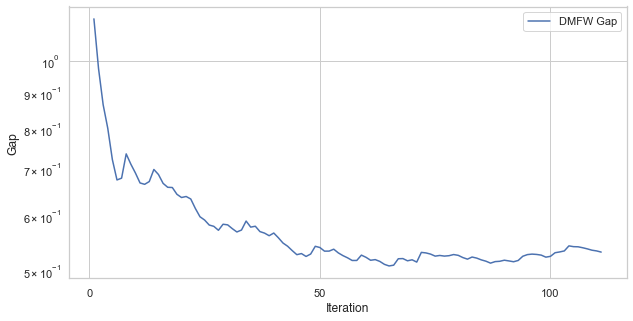

---Hidden Unit 7---
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
{'log':         Iteration      Loss       Gap     Local Gap           Acc  \
0    0.000000e+00  1.090166  1.839660  1.839660e+00  3.007812e-01   
1    1.000000e+00  0.996191  1.442649  1.065526e+00  3.007812e-01   
2    2.000000e+00  0.990302  1.250532  8.712254e-01  3.007812e-01   
3    3.000000e+00  0.893245  1.073403  5.503896e-01  3.007812e-01   
4    4.000000e+00  0.860961  0.963624  5.594614e-01  7.070312e-01   
..            ...       ...       ...           ...           ...   
108  1.080000e+02  0.897673  0.693104  6.392877e-01  6.582031e-01   
109  1.090000e+02  0.846284  0.688842  2.327783e-01  6.582031e-01   
110  1.100000e+02  0.821338  0.686435  4.428301e-01  6.582031e-01   
111  1.110000e+02  0.833335  0.683022  3.585791e-01  6.582031e-01   
112  5.473319e-09  0.000022  0.000003  6.234064e-07  3.142759e-07   

               F1          Prec

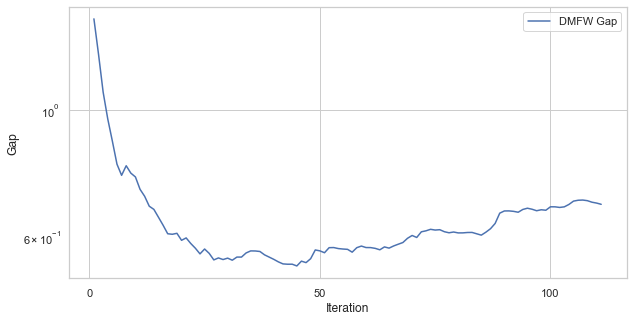

In [13]:
for value in [3,5,7]:
    print(f'---Hidden Unit {value}---')
    path_grid11 = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/tempAC-class-version4/DMFW/complete/floor4/alpha095-cut20april-nb_chan{value}/"
    plotDMFW(path_grid11,None,"Gap",4)
    #plotPrediction(path_grid11,None,"Temperature",str(5),"4",0,10*nb_timestep)

---Hidden Unit 0.75---
['prediction-Floor6Z4.csv']


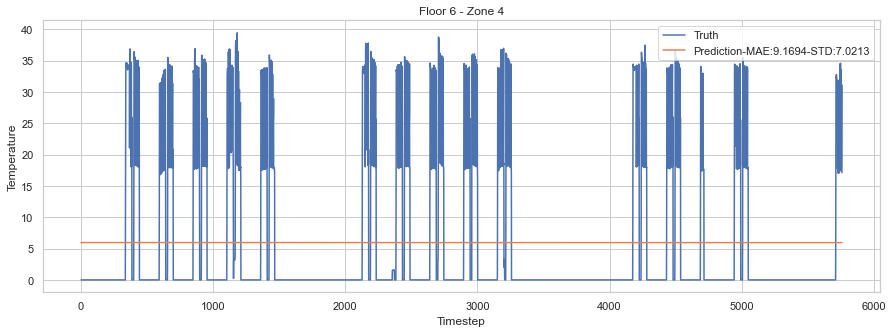

---Hidden Unit 0.8---
['prediction-Floor6Z4.csv']


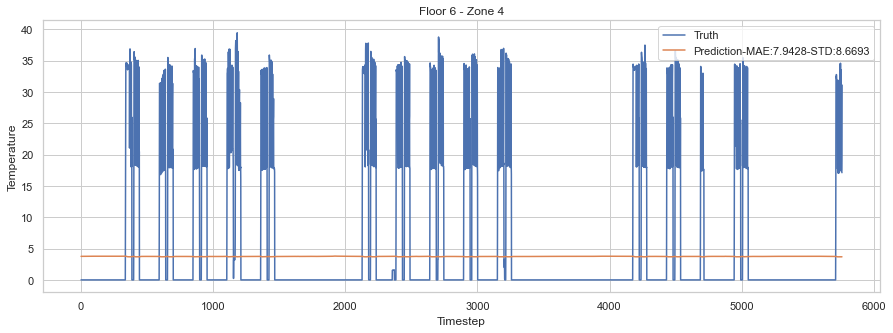

---Hidden Unit 0.85---
['prediction-Floor6Z4.csv']


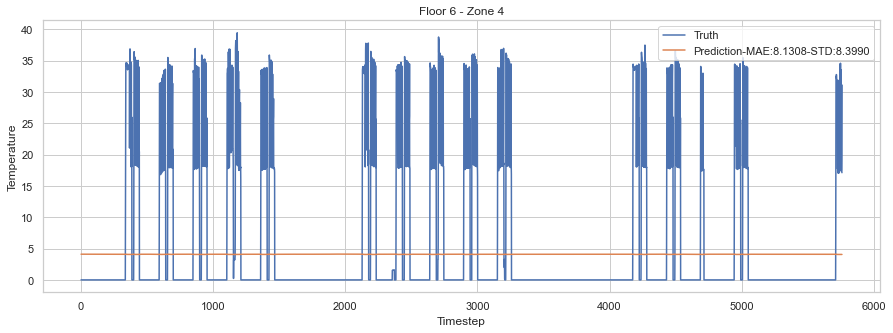

---Hidden Unit 0.9---
['prediction-Floor6Z4.csv']


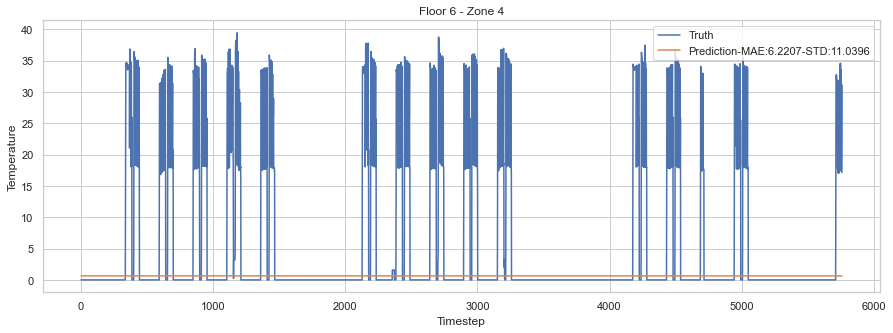

---Hidden Unit 0.95---
['prediction-Floor6Z4.csv']


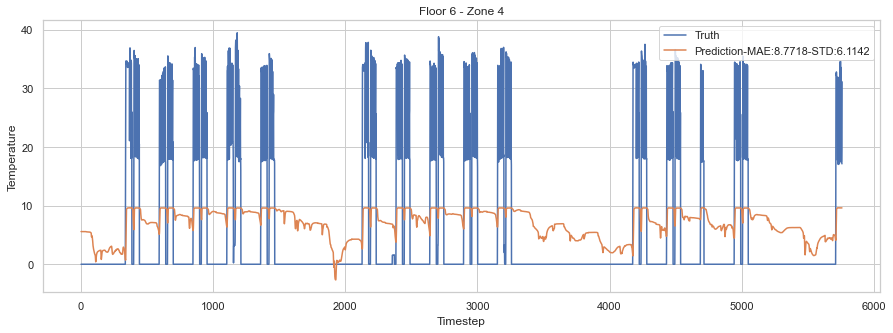

---Hidden Unit 1---
['prediction-Floor6Z4.csv']


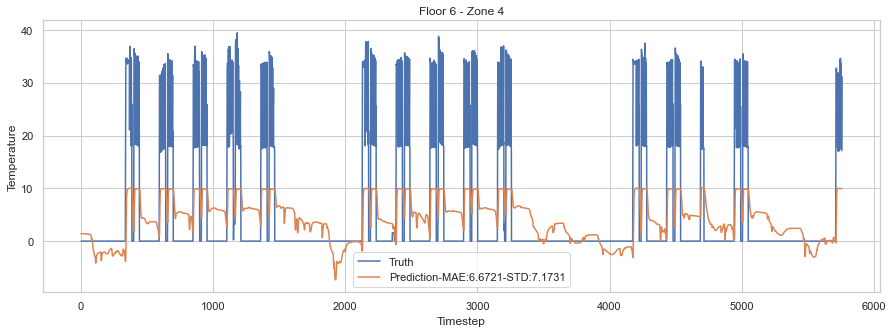

In [23]:
for value in [0.75,0.8,0.85,0.9,0.95,1]:
    print(f'---Hidden Unit {value}---')
    path_grid11 = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/tempAC-version4/DMFW/grid11/floor67/alpha{value}-cut20april-hid64-16/"
    plotPrediction(path_grid11,None,"Temperature",str(4),"6",0,20*nb_timestep)

# Compare 

In [42]:
#path4_avg = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/complete/4Zone/alpha095-cut20april-hid64-64/"
path4 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor4/alpha095-cut20april-hid64-64/"
path5 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor5/alpha095-cut20april-hid64-64/"
path6 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor6/alpha095-cut20april-hid64-64/"

['prediction-Floor4Z1.csv']


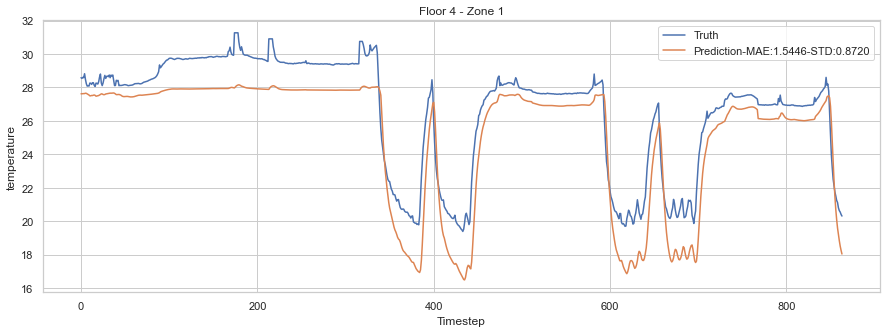

['prediction-Floor4Z2.csv']


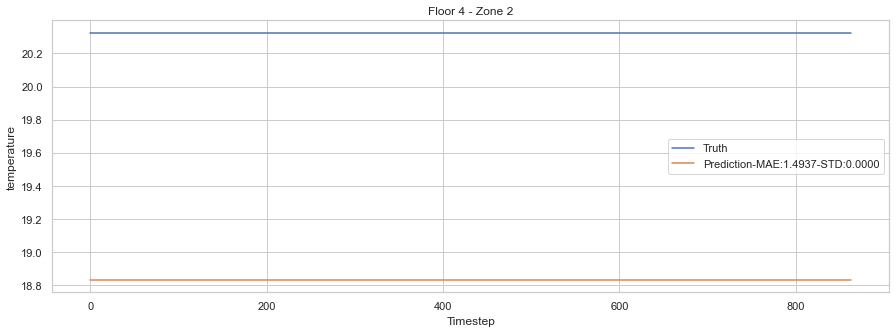

['prediction-Floor4Z4.csv']


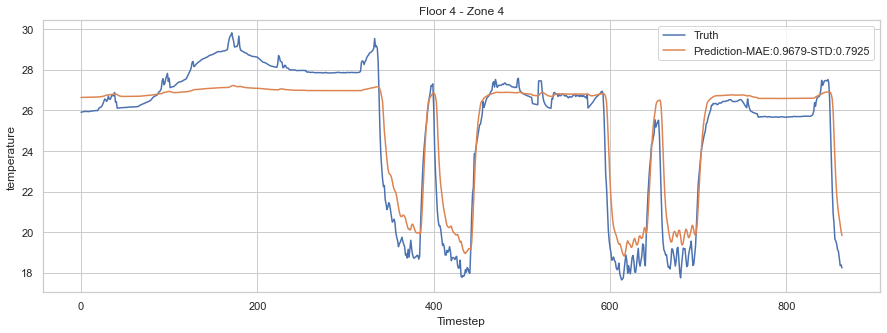

['prediction-Floor4Z5.csv']


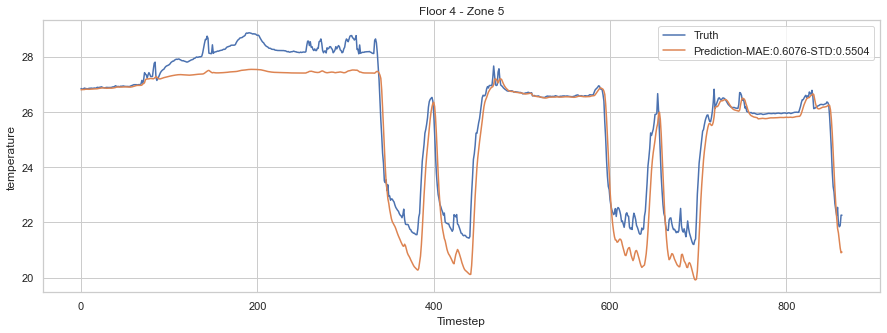

In [43]:
for i in [1,2,4,5]:
    plotPrediction(path4,None,"temperature",str(i),str(4),0, 3*nb_timestep)
    #plotPrediction(path4_normal,None,"temperature",str(i),str(4),0, 3*nb_timestep)

In [64]:
path_new = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/DMFW/complete/floor4567/alpha095-cut20april-removed_floors/"
plotPrediction(path_new, None, "temperature",

TypeError: plotPrediction() missing 7 required positional arguments: 'path', 'path_to_save', 'feature', 'zone_idx', 'floor_idx', 'begin', and 'end'

Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
{'log':         Iteration          Loss           Gap     Local Gap
0    0.000000e+00  6.170382e-01  1.661991e+00  1.661991e+00
1    1.000000e+00  1.770280e-01  1.549430e+00  1.441017e+00
2    2.000000e+00  1.629467e-02  1.115637e+00  2.545756e-01
3    3.000000e+00  8.950803e-02  9.348888e-01  3.970608e-01
4    4.000000e+00  1.481536e-01  9.541215e-01  1.031076e+00
..            ...           ...           ...           ...
356  3.560000e+02  2.220983e-04  2.288975e-01  9.025695e-03
357  3.570000e+02  4.268189e-04  2.284116e-01  6.179927e-02
358  3.580000e+02  2.205527e-04  2.278328e-01  2.132343e-02
359  3.590000e+02  1.142912e-03  2.274531e-01  9.602349e-02
360 -3.354110e-79  1.493449e-78 -1.157419e-80 -2.792825e-77

[361 rows x 4 columns]}


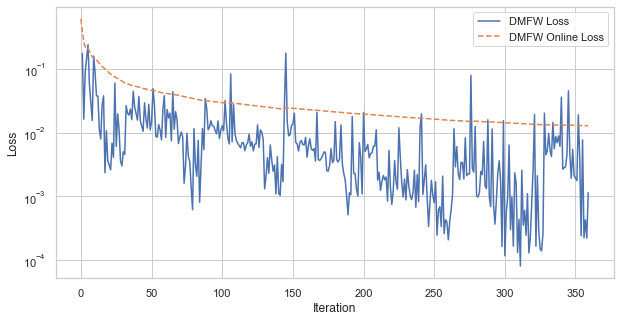

In [46]:
plotDMFW(path6,None,"Loss",4)